# Synthetic Cluster Generation Tutorial Part 1: Data Preparation

Owner: **Tamas Norbert Varga** @vargatn

Last Verifed to Run: 2021-09-30 (by @vargatn)

This notebook will describe how to pre-process the DC2 truth catalog to extract catalog cutouts for redMaPPer cluster line-of-sights. 

**Objectives:**

    * Using the Generic Catalog Reader we will load the DC2 v1.1.4 truth catalog and the positions and properties of redMaPPer clusters.
    * Using healpix disc query, we will then adaptively query the angular vicinity of each cluster
    * Add the angular separation from the cluster as a new column
    * Save the cutout catalog for future calculation for each cluster. 
    * Save three healpix pixel catalogs to give as an estimate of the *field* galaxy population.

Logistics: This notebook is intended to be be run through the This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. using the *desc_stack_weekly* kernel

Other notes:

    * Some of the calculations in this notebook are time consuming, please be mindful of the interactive node resources.
    * some lines are commented out to avoid overwriting previous file outputs on NERSC CSCRATCH
    
Output:

    The results of this notebook are made available on NERSC at /global/cscratch1/sd/tvarga/DC_DATA/dc2_cluster_sim_cutouts


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pickle 

import GCRCatalogs
from GCR import GCRQuery
import healpy as hp

## check version
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 1.3.2 | GCR = 0.9.2


# Loading and  Selecting redMaPPer clusters

In [5]:
redcat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.7.5')

In [6]:
allclust = pd.DataFrame(redcat.get_quantities(['cluster_id', 'ra', 'dec', "richness", "redshift"]))

To select a roughly homogenous target sample, we restrict the richness and redshift range

In [10]:
ii = (allclust["richness"] > 30) & (allclust["richness"] < 60) & (allclust["redshift"] > 0.2) & (allclust["redshift"] < 0.35)
print(ii.sum())
clust = allclust[ii]

110


This relatively broad selectin yields only 110 clusters. these will serve as the targets we will seek to emulate in later stages

Text(0, 0.5, 'DEC [deg]')

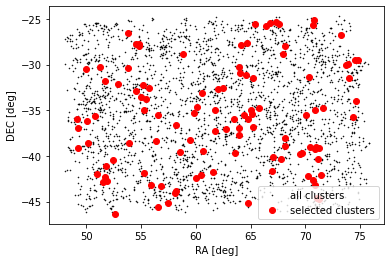

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

bins = (
    np.linspace(clust["ra"].min(), clust["ra"].max(), 100),
    np.linspace(clust["dec"].min(), clust["dec"].max(), 100),
)
#ax.hist2d(dc_pos["ra"], dc_pos["dec"], bins=bins)
ax.scatter(allclust["ra"], allclust["dec"], color="black", s=0.3, label="all clusters")
ax.scatter(clust["ra"], clust["dec"], color="red", label="selected clusters")

ax.legend()

ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")

The cluster in GCR has a mix of cluster and cluster-member related columns, with different lengths respectively. In the following we save both in a format mimicing the public redMaPPer catalogs

In [16]:
keys_clust = []
keys_membs = []
for key in np.sort(redcat.list_all_quantities()):
    #print(key)
    if "member" in key:
        keys_membs.append(key)
    else:
        keys_clust.append(key)
clustcat = pd.DataFrame(redcat.get_quantities(keys_clust))
# clustcat.to_hdf("/global/cscratch1/sd/tvarga/DC_DATA/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_redmapper_v0.7.5_clust.h5", key="data")
membcat = pd.DataFrame(redcat.get_quantities(keys_membs))
# membcat.to_hdf("/global/cscratch1/sd/tvarga/DC_DATA/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_redmapper_v0.7.5_membs.h5", key="data")

# Query galaxies around clusters from DC2

The full DC2 catalog is too big to process directly. While the DC2_small is too small to contain enough galaxy clusters for future calculations. Thus we will make use of the native_filter based on healpix position to select the subset of galaxies around clusters from the full DC2 catalog. 

In [4]:
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image")
cat.native_filter_quantities

['redshift_block_lower', 'healpix_pixel']

The healpix_pixel column assumes nside=32 in the nest=True scheme

We cannot (and should not) load each catalog column from DC2. We will only select a few key colums, these are

In [17]:
quantities = ["galaxy_id", "ra", "dec", "redshift_true",
              "mag_g", "mag_r", "mag_i", "mag_z",
              "Mag_true_g_lsst_z0", "Mag_true_r_lsst_z0", "Mag_true_i_lsst_z0", "Mag_true_z_lsst_z0",
              "size_true", "ellipticity_1_true", "ellipticity_2_true",
              'shear_1', 'shear_2', 'halo_id', 'halo_mass', 'stellar_mass', 'is_central',
             ]

The exact column description is located at https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md

Now we loop over all of the targeted galaxy clusters and query galaxies from the DC2 truth catalog. 

(The below script currently assumes a flat-sky approximation to calculate angular separation. This is suitable for a technical demonstration as DC2 ra, dec positionas are close to the equator.)

**Note** the below cell might take a substantial amount of time to run

In [ ]:
nside = 32
nest = True
search_radius = 20. / 60 # search radius
search_radius_rad = search_radius / 180. * np.pi

available_pixels = np.array(cat.available_healpix_pixels)
for i in np.arange(len(clust)):
    ipix = hp.ang2pix(32, clust["ra"].iloc[i], clust["dec"].iloc[i], lonlat=nest, nest=nest)
    #print(i, ipix, np.where(ipix == available_pixels)[0])
    
    ivec = hp.pix2vec(nside, ipix, nest)
    pixels_to_load = hp.query_disc(nside, ivec, search_radius_rad, inclusive=True)
    print(i, pixels_to_load)
    
    cra = clust["ra"].iloc[i]
    cdec = clust["dec"].iloc[i]
    filters = [
        "ra < {}".format(cra + search_radius),
        "ra > {}".format(cra - search_radius),
        "dec < {}".format(cdec + search_radius),
        "dec > {}".format(cdec - search_radius),
    ] # this is simply a ~ rectangular patch

    _data = []
    for pix in pixels_to_load:
        native_filter = ["healpix_pixel == {}".format(pix)]
        print(native_filter)
        tmp = cat.get_quantities(quantities, filters=filters, native_filters=native_filter)
        __data = pd.DataFrame(tmp)
        _data.append(__data)
    data = pd.concat(_data)
    print("data loaded")
    dist = np.sqrt((cra - data["ra"])**2. + (cdec - data["dec"])**2.)
    data["R"] = dist * 60. # convert distance to arcminutes
    
    cid = clust["cluster_id"].iloc[i]
    oname = "/global/cscratch1/sd/tvarga/DC_DATA/dc2_cluster_sim_cutouts/clust-{}_dc2-sim-cutout.h5".format(cid)
#     data.to_hdf(oname, key="data")
    print("saved", oname)
    
    del __data
    del _data
    del data
    #break

# Saving a few healpix pixels as reference data for the field

Now we extract a sample of galaxies which is representative of the median "field" line-of-sight

In [ ]:
pixels = [8786, 8791, 9937]
for pix in pixels:
    print(pix)
    _refpixel = cat.get_quantities(quantities, native_filters=["healpix_pixel == {}".format(pix)])
    refpixel = pd.DataFrame(_refpixel)
#     refpixel.to_hdf("/global/cscratch1/sd/tvarga/DC_DATA/dc2_cluster_sim_cutouts/cosmoDC2_v1.1.4_refpixel-{}.h5".format(pix), key="data")